# Code to create the topic tables

This involves merging several sources and then translating to LaTeX format.

This notebook also creates ```topic_summary.tsv```.

In [1]:
import pandas as pd
import numpy as np

In [2]:
interpret = pd.read_csv('../interrater/k200standardcoding.tsv', sep = '\t')

In [3]:
root = '../regression/topicmodel_deltas'

deltas = dict()

for i in range(1, 6):
    
    suffix = str(i) + '.csv'
    deltas[i] = pd.read_csv(root + suffix)
    
print(len(deltas), ' files loaded.')

5  files loaded.


In [4]:
smoothed = dict()

cols = ['delta', 'adjdelta', 'delta_oos', 'cmse', 'pmse', 'cmse_oos', 'pmse_oos', 
        'totalr2', 'r2_oos', 'bydf', 'fpdf', 'agemse']

for c in cols:
    if c not in smoothed:
        smoothed[c] = []
    for rownum in range(200):
        values = []
        for i in range(1, 6):
            if c in deltas[i].columns:      # the only exception is 'agemse' which got added late
                                            # and won't be in all five runs
                values.append(deltas[i].loc[rownum, c])
        smoothed[c].append(np.mean(values))

        
avgdf = pd.DataFrame(smoothed)

In [5]:
avgdf.head()

,delta,adjdelta,delta_oos,cmse,pmse,cmse_oos,pmse_oos,totalr2,r2_oos,bydf,fpdf,agemse
0,0.052664,0.185230,0.078345,11.6860,209.5212,0.020000,0.102817,0.047869,0.024379,6.2,24.0,0.53325
1,0.578712,0.596288,0.689357,25.0768,16.0822,0.061597,0.017510,0.017090,0.003942,4.8,6.0,2.13175
2,0.642251,0.671377,0.433169,16.1334,9.5950,0.012027,0.011970,0.006939,-0.004519,4.8,5.4,2.73375
3,0.238089,0.454468,0.140974,46.8034,151.2078,0.029488,0.198506,0.136532,0.122522,5.6,16.0,9.89675
4,0.783425,0.661006,0.809441,61.5444,17.3744,0.078168,0.020837,0.028121,0.011077,8.6,4.8,4.91075


For the record, two column names are misleading: cmse_oos and pmse_oos are really r2: scaled to dataset variance.

In [6]:
interpret.head()

,topicstats,keywords,top7books,"next5books, biggestauth, datequartiles",label,category,comments
0,TOPIC 0 pct corpus = 0.267% doc entropy = 9.80...,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","0.12 | Sweetser, Arthur | Roadside glimpses of...","war, mostly WWII",event,"Although hitler and nazi are keywords, we can ..."
1,TOPIC 1 pct corpus = 0.288% doc entropy = 9.74...,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","0.147 | Wells, H. G. (Herbert George) | Star-b...","e20c scientists, labs, and professors, mostly ...",genre,I've changed my mind here twice. The topic is ...
2,TOPIC 2 pct corpus = 0.479% doc entropy = 10.4...,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","0.122 | Axline, Virginia Mae | Dibs: in search...","objects in relation to doors, pockets, rooms, ...",physical description,"Notice relatively high document entropy, and ..."
3,TOPIC 3 pct corpus = 0.388% doc entropy = 9.34...,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...","0.243 | Clancy, Tom | The sum of all fears | 1...",late 20c US political thrillers,genre,"Low doc entropy, high number of rank-1 docs; t..."
4,TOPIC 4 pct corpus = 0.666% doc entropy = 10.3...,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...","0.123 | Onadipe, Kola | The king is naked : an...",diffuse,uncategorized dimension of style,A pretty diffuse topic. The books come from di...


In [7]:
interpret = interpret.assign(delta = avgdf.delta.values)
interpret = interpret.assign(r2 = avgdf.totalr2.values)

In [8]:
for i in [0, 50, 100, 150]:

    outlines = []

    outlines.append('\\begin{tabular}{lllrr}\n')
    outlines.append('Topic label & category & keywords & delta & total r2 \\\\\n')
    outlines.append('\midrule\n')

    for idx in range(i, i + 50):
        row = interpret.iloc[idx, : ]
        label = row['label'].replace('&', 'and')
        label = label[0].upper() + label[1:]
        if len(label) > 40:
            label = label[0:40]
        
        category = row['category']
        
        if category == 'human institutions, practices, or relationships':
            category = 'institutions, practices, relationships'
        if category == 'uncategorized dimension of style':
            category = 'uncategorized'

        keywords = ' '.join(row['keywords'].split()[0:5])

        newline = str(idx) + '. ' + label + ' & ' + category + ' & ' + keywords + ' & ' + str(round(row['delta'], 2)) + ' & ' + str(round(row['r2'], 3)) + '\\\\\n'
        outlines.append(newline)

    outlines.append('\\bottomrule\n')
    outlines.append('\end{tabular}\n')
    outlines.append('\end{table}\n') 
    
    with open('SItable' + str(i) + '.txt', mode = 'w', encoding = 'utf-8') as f:
        for line in outlines:
            f.write(line)

## Make summary_table.tsv to document model

Right now information about topics is scattered across six different files, and all the code above was needed to reconstruct it.

Readers of our article shouldn't have to do all that. Let's assemble the data for them.

In [9]:
print(interpret.shape)
print(avgdf.shape)

(200, 9)
(200, 12)


In [14]:
summary = pd.concat([interpret, avgdf], axis = 1)
summary.shape

(200, 21)

In [15]:
summary.columns

Index(['topicstats', 'keywords', 'top7books',
       'next5books, biggestauth, datequartiles', 'label', 'category',
       'comments', 'delta', 'r2', 'delta', 'adjdelta', 'delta_oos', 'cmse',
       'pmse', 'cmse_oos', 'pmse_oos', 'totalr2', 'r2_oos', 'bydf', 'fpdf',
       'agemse'],
      dtype='object')

In [16]:
summary = summary.rename(columns = {'cmse_oos': 'cohortr2_oos', 'pmse_oos': 'periodr2_oos', 'pmse': 'periodmse', 'cmse': 'cohortmse', 
                                    'bydf': 'birthyear_meangranularity', 'fpdf': 'firstpub_meangranularity'})
summary.columns

Index(['topicstats', 'keywords', 'top7books',
       'next5books, biggestauth, datequartiles', 'label', 'category',
       'comments', 'delta', 'r2', 'delta', 'adjdelta', 'delta_oos',
       'cohortmse', 'periodmse', 'cohortr2_oos', 'periodr2_oos', 'totalr2',
       'r2_oos', 'birthyear_meangranularity', 'firstpub_meangranularity',
       'agemse'],
      dtype='object')

In [17]:
def getpct(astring):
    firstpart = astring.split('%')[0]
    number = float(firstpart.split('= ')[1])
    return number

def getremainder(astring):
    lastpart = astring.split('%', 1)[1]
    return lastpart

summary = summary.assign(topicsize = summary.topicstats.map(getpct))
summary = summary.assign(topicstats = summary.topicstats.map(getremainder))
summary.head()

,topicstats,keywords,top7books,"next5books, biggestauth, datequartiles",label,category,comments,delta,r2,delta,...,cohortmse,periodmse,cohortr2_oos,periodr2_oos,totalr2,r2_oos,birthyear_meangranularity,firstpub_meangranularity,agemse,topicsize
0,doc entropy = 9.8055 word length = 5.2200 coh...,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","0.12 | Sweetser, Arthur | Roadside glimpses of...","war, mostly WWII",event,"Although hitler and nazi are keywords, we can ...",0.052664,0.047869,0.052664,...,11.6860,209.5212,0.020000,0.102817,0.047869,0.024379,6.2,24.0,0.53325,0.267
1,doc entropy = 9.7455 word length = 5.2350 coh...,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","0.147 | Wells, H. G. (Herbert George) | Star-b...","e20c scientists, labs, and professors, mostly ...",genre,I've changed my mind here twice. The topic is ...,0.578712,0.017090,0.578712,...,25.0768,16.0822,0.061597,0.017510,0.017090,0.003942,4.8,6.0,2.13175,0.288
2,doc entropy = 10.4816 word length = 4.5600 co...,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","0.122 | Axline, Virginia Mae | Dibs: in search...","objects in relation to doors, pockets, rooms, ...",physical description,"Notice relatively high document entropy, and ...",0.642251,0.006939,0.642251,...,16.1334,9.5950,0.012027,0.011970,0.006939,-0.004519,4.8,5.4,2.73375,0.479
3,doc entropy = 9.3409 word length = 5.1800 coh...,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...","0.243 | Clancy, Tom | The sum of all fears | 1...",late 20c US political thrillers,genre,"Low doc entropy, high number of rank-1 docs; t...",0.238089,0.136532,0.238089,...,46.8034,151.2078,0.029488,0.198506,0.136532,0.122522,5.6,16.0,9.89675,0.388
4,doc entropy = 10.3139 word length = 4.7500 co...,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...","0.123 | Onadipe, Kola | The king is naked : an...",diffuse,uncategorized dimension of style,A pretty diffuse topic. The books come from di...,0.783425,0.028121,0.783425,...,61.5444,17.3744,0.078168,0.020837,0.028121,0.011077,8.6,4.8,4.91075,0.666


In [18]:
summary = summary.loc[ : , [ 'label', 'category', 'topicsize', 'delta', 'r2', 'cohortmse', 'periodmse', 'agemse', 
                            'delta_oos', 'r2_oos', 'cohortr2_oos', 'periodr2_oos', 
                           'keywords', 'top7books', 'next5books, biggestauth, datequartiles', 'comments']]

In [19]:
summary.to_csv('../topic_summary.tsv', sep = '\t', index = False)

## Heat map of bin widths

When we allow model specification to be decided by out-of-sample accuracy, what specifications get chosen?

In [46]:
from collections import Counter

tuplectr = Counter()

r2list = dict()

for i in range(1, 6):
    for idx, row in deltas[i].iterrows():
        thetuple = (int(row['bywidth'].split('_')[1]), int(row['fpwidth'].split('_')[1]))
        tuplectr[thetuple] += 1
        if thetuple not in r2list:
            r2list[thetuple] = []
        r2list[thetuple].append(row['totalr2'])

In [51]:
birthyear_width = []
firstpub_width = []
counts = []

zerobar = np.zeros(6)

countdf = pd.DataFrame({4: zerobar, 8: zerobar, 12: zerobar,
                  16: zerobar, 20: zerobar, 24: zerobar}, index = [4, 8, 12, 16, 20, 24])

r2df = pd.DataFrame({4: zerobar, 8: zerobar, 12: zerobar,
                  16: zerobar, 20: zerobar, 24: zerobar}, index = [4, 8, 12, 16, 20, 24])

for k, v in tuplectr.items():
    countdf.at[k[0], k[1]] = v

for k, v in r2list.items():
    
    r2df.at[k[0], k[1]] = round(np.mean(v), 3)
    
countdf.head()

,4,8,12,16,20,24
4,2.0,4.0,2.0,6.0,1.0,0.0
8,2.0,5.0,5.0,5.0,7.0,5.0
12,11.0,10.0,24.0,26.0,18.0,23.0
16,12.0,18.0,23.0,26.0,29.0,41.0
20,28.0,65.0,54.0,64.0,66.0,90.0


In [52]:
r2df.head()

,4,8,12,16,20,24
4,0.137,0.145,0.108,0.073,0.034,0.000
8,0.148,0.120,0.116,0.077,0.091,0.108
12,0.087,0.078,0.073,0.048,0.056,0.053
16,0.171,0.080,0.044,0.061,0.040,0.028
20,0.107,0.062,0.041,0.042,0.033,0.035


In [45]:
deltas[1].head()

,depvar,cmse,pmse,totalr2,delta,adjdelta,bywidth,fpwidth,bydf,fpdf,pmse_oos,cmse_oos,delta_oos,r2_oos
0,t0,10.625,208.397,0.047679,0.048511,0.196610,by_20,fp_4,5,24,0.071000,0.003257,0.043864,0.027340
1,t1,4.319,25.653,0.013992,0.144101,0.201625,by_24,fp_16,4,6,0.029850,0.002211,0.068966,0.006283
2,t2,8.787,1.994,0.005109,0.815045,0.767714,by_24,fp_24,4,3,0.002117,0.002472,0.538668,-0.003695
3,t3,45.574,167.528,0.139734,0.213860,0.566308,by_20,fp_4,5,24,0.215235,0.029488,0.120495,0.122961
4,t4,59.187,13.012,0.027322,0.819776,0.630416,by_16,fp_24,8,3,0.012454,0.058356,0.824115,0.014960


In [33]:
import seaborn as sns
from matplotlib import pyplot as plt

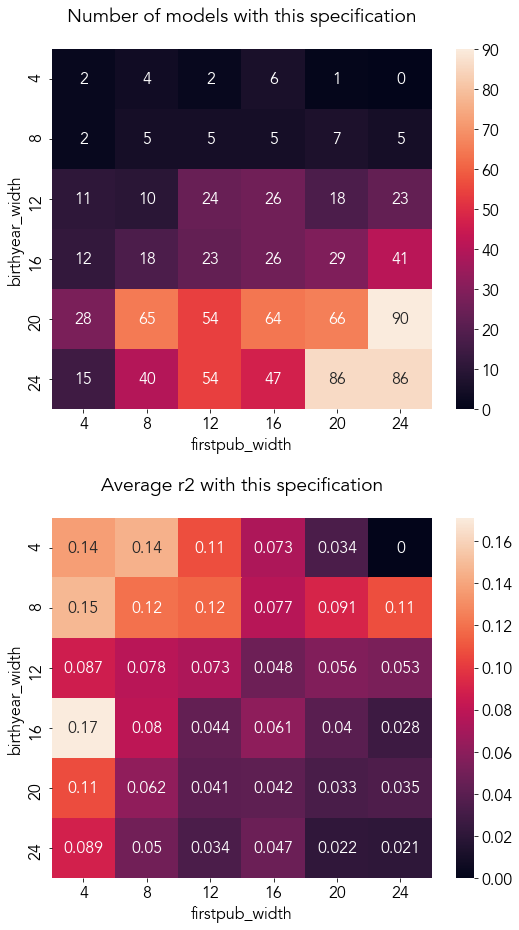

In [62]:
figure, axs = plt.subplots(2, figsize = (9, 14))

countdf = countdf.rename_axis('firstpub_width', axis = 'columns')
countdf = countdf.rename_axis("birthyear_width", axis = 'rows')

r2df = r2df.rename_axis('firstpub_width', axis = 'columns')
r2df = r2df.rename_axis("birthyear_width", axis = 'rows')

sns.heatmap(countdf, ax = axs[0], annot=True)
sns.heatmap(r2df, ax = axs[1], annot=True)

figure.tight_layout(pad=4.0)

axs[0].set_title('Number of models with this specification\n')
axs[1].set_title('Average r2 with this specification\n')

plt.rcParams.update({'font.sans-serif':'Avenir'})
plt.rcParams.update({'font.size': 16})
plt.gcf().set_facecolor('white')

plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/model_specification_heatmap.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [38]:
df.to_numpy().sum()

1000.0

In [68]:
from scipy.stats import pearsonr
pearsonr(deltas[1].delta, deltas[1].bydf / deltas[1].fpdf)

(0.4830984600210496, 4.318794898199666e-13)

In [69]:
pearsonr(deltas[1].cmse, deltas[1].bydf)

(0.5398390089234323, 1.598791015742952e-16)

In [70]:
pearsonr(deltas[1].pmse, deltas[1].fpdf)

(0.5618850503059718, 4.867455110582154e-18)

In [73]:
sum(deltas[5].agemse) / (sum(deltas[5].cmse) + sum(deltas[5].pmse) + sum(deltas[5].agemse))

0.06336232363460742